# Лабораторная работа 5.1: Логистическая регрессия

## Федоров Александр

## Задача 1: Бинарная логистическая регрессия

Реализовать класс `MyBinaryLogisticRegression` для работы с логистической регрессией. Обеспечить возможность использования `l1`, `l2` и `l1l2` регуляризации и реализовать следующие методы решения оптимизационной задачи:

*   Градиентный спуск
*   Стохастический градиентный спуск
*   Метод Ньютона

Обосновать применимость/не применимость того или иного метода оптимизации в случае использованного типа регуляризации.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# Настройка для красивого отображения
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")
np.random.seed(42)

In [2]:
class MyBinaryLogisticRegression:
    """
    Класс для реализации бинарной логистической регрессии с различными методами оптимизации и регуляризацией.
    
    Parameters
    ----------
    regularization : str, default=None
        Тип регуляризации: None, 'l1', 'l2', 'l1l2'
    lambda_1 : float, default=None
        Коэффициент L1 регуляризации
    lambda_2 : float, default=None
        Коэффициент L2 регуляризации
    method : str, default='gd'
        Метод оптимизации: 'gd', 'sgd', 'newton'
    alpha : float, default=0.01
        Шаг обучения для градиентного спуска
    batch_size : int, default=32
        Размер батча для SGD
    max_iter : int, default=1000
        Максимальное количество итераций
    tol : float, default=1e-6
        Точность сходимости
    random_state : int, default=42
        Зерно для воспроизводимости
    """
    
    def __init__(self, regularization=None, lambda_1=None, lambda_2=None, 
                 method='gd', alpha=0.01, batch_size=32, max_iter=1000, 
                 tol=1e-6, random_state=42):
        self.regularization = regularization
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.method = method
        self.alpha = alpha
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.coefs_ = None
        self.intercept_ = None
        self.feature_names_in_ = None
        self.loss_history_ = []
        
        # Проверка совместимости метода и регуляризации
        if regularization == 'l1' and method == 'newton':
            raise ValueError("Метод Ньютона не применим для L1 регуляризации (недифференцируемая функция)")
        if regularization == 'l1l2' and method == 'newton':
            raise ValueError("Метод Ньютона не применим для L1L2 регуляризации (недифференцируемая функция)")
    
    def _sigmoid(self, z):
        """Сигмоидная функция"""
        # Защита от переполнения
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _loss(self, w, X, y):
        """Функция потерь с регуляризацией"""
        n = X.shape[0]
        z = X @ w
        predictions = self._sigmoid(z)
        
        # Бинарная кросс-энтропия
        loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
        
        # Регуляризация (не применяем к intercept)
        if self.regularization == 'l1' and self.lambda_1 is not None:
            loss += self.lambda_1 * np.sum(np.abs(w[1:]))
        elif self.regularization == 'l2' and self.lambda_2 is not None:
            loss += self.lambda_2 * np.sum(w[1:]**2)
        elif self.regularization == 'l1l2':
            if self.lambda_1 is not None:
                loss += self.lambda_1 * np.sum(np.abs(w[1:]))
            if self.lambda_2 is not None:
                loss += self.lambda_2 * np.sum(w[1:]**2)
        
        return loss
    
    def _gradient(self, w, X, y):
        """Градиент функции потерь"""
        n = X.shape[0]
        z = X @ w
        predictions = self._sigmoid(z)
        
        # Градиент бинарной кросс-энтропии
        grad = X.T @ (predictions - y) / n
        
        # Добавляем регуляризацию (не применяем к intercept)
        if self.regularization == 'l1' and self.lambda_1 is not None:
            grad[1:] += self.lambda_1 * np.sign(w[1:])
        elif self.regularization == 'l2' and self.lambda_2 is not None:
            grad[1:] += 2 * self.lambda_2 * w[1:]
        elif self.regularization == 'l1l2':
            if self.lambda_1 is not None:
                grad[1:] += self.lambda_1 * np.sign(w[1:])
            if self.lambda_2 is not None:
                grad[1:] += 2 * self.lambda_2 * w[1:]
        
        return grad
    
    def _hessian(self, w, X, y):
        """Гессиан функции потерь (только для L2 регуляризации или без регуляризации)"""
        n = X.shape[0]
        z = X @ w
        predictions = self._sigmoid(z)
        
        # Диагональная матрица с производными сигмоиды
        S = np.diag(predictions * (1 - predictions))
        
        # Гессиан бинарной кросс-энтропии
        H = X.T @ S @ X / n
        
        # Добавляем L2 регуляризацию (не применяем к intercept)
        if self.regularization == 'l2' and self.lambda_2 is not None:
            reg_matrix = np.eye(len(w))
            reg_matrix[0, 0] = 0  # Не регуляризуем intercept
            H += 2 * self.lambda_2 * reg_matrix
        elif self.regularization == 'l1l2' and self.lambda_2 is not None:
            reg_matrix = np.eye(len(w))
            reg_matrix[0, 0] = 0
            H += 2 * self.lambda_2 * reg_matrix
        
        return H
    
    def _gd_fit(self, X, y):
        """Градиентный спуск"""
        n_features = X.shape[1]
        w = np.random.normal(0, 0.01, n_features)
        
        for i in range(self.max_iter):
            grad = self._gradient(w, X, y)
            w_new = w - self.alpha * grad
            
            # Проверка сходимости
            if np.linalg.norm(w_new - w) < self.tol:
                break
            
            loss = self._loss(w_new, X, y)
            self.loss_history_.append(loss)
            w = w_new
        
        return w
    
    def _sgd_fit(self, X, y):
        """Стохастический градиентный спуск"""
        n_samples, n_features = X.shape
        w = np.random.normal(0, 0.01, n_features)
        
        np.random.seed(self.random_state)
        for i in range(self.max_iter):
            # Случайная выборка батча
            indices = np.random.choice(n_samples, size=min(self.batch_size, n_samples), replace=False)
            X_batch = X[indices]
            y_batch = y[indices]
            
            grad = self._gradient(w, X_batch, y_batch)
            w_new = w - self.alpha * grad
            
            # Проверка сходимости
            if np.linalg.norm(w_new - w) < self.tol:
                break
            
            loss = self._loss(w, X, y)
            self.loss_history_.append(loss)
            w = w_new
        
        return w
    
    def _newton_fit(self, X, y):
        """Метод Ньютона (только для L2 или без регуляризации)"""
        n_features = X.shape[1]
        w = np.random.normal(0, 0.01, n_features)
        
        for i in range(self.max_iter):
            grad = self._gradient(w, X, y)
            H = self._hessian(w, X, y)
            
            # Решение системы H * delta = -grad
            try:
                delta = np.linalg.solve(H, -grad)
            except np.linalg.LinAlgError:
                # Если матрица вырождена, используем псевдообратную
                delta = -np.linalg.pinv(H) @ grad
            
            w_new = w + delta
            
            # Проверка сходимости
            if np.linalg.norm(w_new - w) < self.tol:
                break
            
            loss = self._loss(w_new, X, y)
            self.loss_history_.append(loss)
            w = w_new
        
        return w
    
    def fit(self, X, y):
        """Обучение модели"""
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
            X = X.values
        
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
        
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        
        # Выбираем метод оптимизации
        if self.method == 'gd':
            w = self._gd_fit(X_with_intercept, y)
        elif self.method == 'sgd':
            w = self._sgd_fit(X_with_intercept, y)
        elif self.method == 'newton':
            w = self._newton_fit(X_with_intercept, y)
        else:
            raise ValueError(f"Неизвестный метод оптимизации: {self.method}")
        
        self.intercept_ = w[0]
        self.coefs_ = w[1:]
        
        return self
    
    def predict_proba(self, X):
        """Вероятности принадлежности классу 1"""
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        w = np.concatenate([[self.intercept_], self.coefs_])
        z = X_with_intercept @ w
        return self._sigmoid(z)
    
    def predict(self, X, threshold=0.5):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        return (proba >= threshold).astype(int)
    
    def score(self, X, y):
        """F1-score"""
        y_pred = self.predict(X)
        return f1_score(y, y_pred)

### Обоснование применимости методов оптимизации

**Градиентный спуск (GD):**
- ✅ Применим для всех типов регуляризации (l1, l2, l1l2, без регуляризации)
- L1 регуляризация недифференцируема в нуле, но можно использовать субградиент

**Стохастический градиентный спуск (SGD):**
- ✅ Применим для всех типов регуляризации
- Эффективен для больших датасетов
- L1 регуляризация: используется субградиент

**Метод Ньютона:**
- ✅ Применим только для L2 регуляризации или без регуляризации
- ❌ НЕ применим для L1 и L1L2 регуляризации
- Причина: L1 регуляризация недифференцируема, гессиан не существует в точках, где веса равны нулю


## Задача 2: Применение на датасете пингвинов

Продемонстрировать применение реализованного класса на датасете про пингвинов (целевая переменная — вид пингвина). Рассмотреть все возможные варианты (регуляризация/оптимизация). Для категориального признака `island` реализовать самостоятельно преобразование `Target Encoder`, сравнить результаты классификации с `one-hot`. В качестве метрики использовать `f1-score`.


In [3]:
# Загрузка данных
df = pd.read_csv('penguins_binary_classification.csv')
print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
print(df.head())
print(f"\nИнформация о данных:")
print(df.info())
print(f"\nРаспределение классов:")
print(df['species'].value_counts())


Размер датасета: (274, 7)

Первые строки:
  species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen            36.7           19.3              193.0   
4  Adelie  Torgersen            39.3           20.6              190.0   

   body_mass_g  year  
0       3750.0  2007  
1       3800.0  2007  
2       3250.0  2007  
3       3450.0  2007  
4       3650.0  2007  

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            274 non-null    object 
 1   island             274 non-null    object 
 2   bill_length_mm     274 non-null    float64
 3   bill

In [4]:
# Проверка на пропуски
print("Пропущенные значения:")
print(df.isnull().sum())
print(f"\nВсего пропусков: {df.isnull().sum().sum()}")

# Удаление пропусков
df_clean = df.dropna()
print(f"\nРазмер после удаления пропусков: {df_clean.shape}")

# Преобразование целевой переменной в бинарную (Adelie = 0, Gentoo = 1)
df_clean['target'] = (df_clean['species'] == 'Gentoo').astype(int)
print(f"\nРаспределение целевой переменной:")
print(df_clean['target'].value_counts())


Пропущенные значения:
species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
year                 0
dtype: int64

Всего пропусков: 0

Размер после удаления пропусков: (274, 7)

Распределение целевой переменной:
target
0    151
1    123
Name: count, dtype: int64


In [5]:
# Реализация Target Encoder
class TargetEncoder:
    """
    Target Encoder для категориальных признаков.
    Кодирует категории средним значением целевой переменной по этой категории.
    """
    
    def __init__(self, smoothing=1.0):
        self.smoothing = smoothing
        self.encodings = {}
        self.global_mean = None
    
    def fit(self, X, y):
        """Обучение энкодера"""
        self.global_mean = y.mean()
        
        for category in X.unique():
            category_mask = X == category
            category_mean = y[category_mask].mean()
            category_count = category_mask.sum()
            
            # Сглаживание: взвешенное среднее между средним по категории и глобальным средним
            smoothed_mean = (category_count * category_mean + self.smoothing * self.global_mean) / (category_count + self.smoothing)
            self.encodings[category] = smoothed_mean
        
        return self
    
    def transform(self, X):
        """Преобразование признака"""
        return X.map(self.encodings).fillna(self.global_mean)
    
    def fit_transform(self, X, y):
        """Обучение и преобразование"""
        return self.fit(X, y).transform(X)


In [6]:
# Подготовка данных: числовые признаки
numeric_features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year']
X_numeric = df_clean[numeric_features].copy()
y = df_clean['target'].copy()

# Разделение на train/test
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42, stratify=y
)

# Масштабирование числовых признаков
scaler = StandardScaler()
X_train_num_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_num),
    columns=X_train_num.columns,
    index=X_train_num.index
)
X_test_num_scaled = pd.DataFrame(
    scaler.transform(X_test_num),
    columns=X_test_num.columns,
    index=X_test_num.index
)

print(f"Размер обучающей выборки: {X_train_num_scaled.shape}")
print(f"Размер тестовой выборки: {X_test_num_scaled.shape}")


Размер обучающей выборки: (219, 5)
Размер тестовой выборки: (55, 5)


In [7]:
# Вариант 1: One-Hot Encoding для island
island_train = df_clean.loc[X_train_num.index, 'island']
island_test = df_clean.loc[X_test_num.index, 'island']

X_train_onehot = pd.get_dummies(island_train, prefix='island')
X_test_onehot = pd.get_dummies(island_test, prefix='island')

# Убеждаемся, что в тесте есть те же колонки, что и в трейне
X_test_onehot = X_test_onehot.reindex(columns=X_train_onehot.columns, fill_value=0)

# Объединяем числовые признаки и one-hot
X_train_1 = pd.concat([X_train_num_scaled.reset_index(drop=True), 
                       X_train_onehot.reset_index(drop=True)], axis=1)
X_test_1 = pd.concat([X_test_num_scaled.reset_index(drop=True), 
                     X_test_onehot.reset_index(drop=True)], axis=1)

print("One-Hot Encoding:")
print(f"Обучающая выборка: {X_train_1.shape}")
print(f"Тестовая выборка: {X_test_1.shape}")
print(f"\nПризнаки: {X_train_1.columns.tolist()}")


One-Hot Encoding:
Обучающая выборка: (219, 8)
Тестовая выборка: (55, 8)

Признаки: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'year', 'island_Biscoe', 'island_Dream', 'island_Torgersen']


In [8]:
# Вариант 2: Target Encoding для island
target_encoder = TargetEncoder(smoothing=1.0)
island_train_encoded = target_encoder.fit_transform(island_train, y_train)
island_test_encoded = target_encoder.transform(island_test)

# Объединяем числовые признаки и target-encoded island
X_train_2 = pd.concat([X_train_num_scaled.reset_index(drop=True), 
                       pd.Series(island_train_encoded.values, name='island_encoded')], axis=1)
X_test_2 = pd.concat([X_test_num_scaled.reset_index(drop=True), 
                     pd.Series(island_test_encoded.values, name='island_encoded')], axis=1)

print("Target Encoding:")
print(f"Обучающая выборка: {X_train_2.shape}")
print(f"Тестовая выборка: {X_test_2.shape}")
print(f"\nКодировки island:")
for island, encoding in target_encoder.encodings.items():
    print(f"  {island}: {encoding:.4f}")


Target Encoding:
Обучающая выборка: (219, 6)
Тестовая выборка: (55, 6)

Кодировки island:
  Biscoe: 0.7402
  Dream: 0.0097
  Torgersen: 0.0104


In [9]:
# Проверка, что класс определен
try:
    test_model = MyBinaryLogisticRegression()
    print("✓ Класс MyBinaryLogisticRegression успешно определен")
except NameError as e:
    print(f"✗ ОШИБКА: Класс MyBinaryLogisticRegression не определен!")
    print("Пожалуйста, выполните ячейку с определением класса (ячейка 3)")
    raise

# Проверка, что данные подготовлены
try:
    _ = X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test
    print("✓ Данные подготовлены")
except NameError as e:
    print("✗ ОШИБКА: Данные не подготовлены!")
    error_msg = str(e)
    var_name = error_msg.split("'")[1] if "'" in error_msg else 'неизвестная'
    print(f"Отсутствует переменная: {var_name}")
    print("Пожалуйста, выполните ячейки с подготовкой данных (ячейки 6-11)")
    raise

# Эксперименты со всеми комбинациями методов и регуляризации
results = []

# Параметры для экспериментов
methods = ['gd', 'sgd', 'newton']
regularizations = [None, 'l1', 'l2', 'l1l2']

# Для каждого варианта кодирования
for encoding_type, X_train, X_test in [('onehot', X_train_1, X_test_1), ('target', X_train_2, X_test_2)]:
    print(f"\n{'='*60}")
    print(f"Кодирование: {encoding_type.upper()}")
    print(f"{'='*60}")
    
    for method in methods:
        for reg in regularizations:
            # Пропускаем несовместимые комбинации
            if reg == 'l1' and method == 'newton':
                continue
            if reg == 'l1l2' and method == 'newton':
                continue
            
            # Выбираем lambda в зависимости от типа регуляризации
            if reg is None:
                lambda_1, lambda_2 = None, None
            elif reg == 'l1':
                lambda_1, lambda_2 = 0.1, None
            elif reg == 'l2':
                lambda_1, lambda_2 = None, 0.1
            elif reg == 'l1l2':
                lambda_1, lambda_2 = 0.01, 0.1
            
            try:
                model = MyBinaryLogisticRegression(
                    regularization=reg,
                    lambda_1=lambda_1,
                    lambda_2=lambda_2,
                    method=method,
                    alpha=0.01,
                    max_iter=1000,
                    random_state=42
                )
                
                model.fit(X_train, y_train.reset_index(drop=True))
                f1 = model.score(X_test, y_test.reset_index(drop=True))
                acc = accuracy_score(y_test.reset_index(drop=True), model.predict(X_test))
                
                results.append({
                    'encoding': encoding_type,
                    'method': method,
                    'regularization': reg if reg else 'none',
                    'lambda_1': lambda_1,
                    'lambda_2': lambda_2,
                    'f1_score': f1,
                    'accuracy': acc,
                    'n_iter': len(model.loss_history_)
                })
                
                print(f"{method.upper():6s} | {str(reg):8s} | F1: {f1:.4f} | Acc: {acc:.4f}")
                
            except Exception as e:
                print(f"{method.upper():6s} | {str(reg):8s} | ОШИБКА: {str(e)}")

# Создаем DataFrame только если есть результаты
if len(results) > 0:
    results_df = pd.DataFrame(results)
    print(f"\n✓ Успешно выполнено экспериментов: {len(results)}")
else:
    print("\n✗ ВНИМАНИЕ: Не удалось выполнить ни одного эксперимента!")
    print("Проверьте, что класс MyBinaryLogisticRegression определен и все зависимости установлены.")
    results_df = pd.DataFrame()  # Пустой DataFrame для избежания ошибок


✓ Класс MyBinaryLogisticRegression успешно определен
✓ Данные подготовлены

Кодирование: ONEHOT
GD     | None     | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
GD     | l1       | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
GD     | l2       | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
GD     | l1l2     | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
SGD    | None     | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
SGD    | l1       | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
SGD    | l2       | ОШИБКА: loop of ufunc does not support argument 0 of type float which has no callable exp method
SGD    | l1l2     | ОШИБКА: loop of ufunc does not support argument 0 of type float w

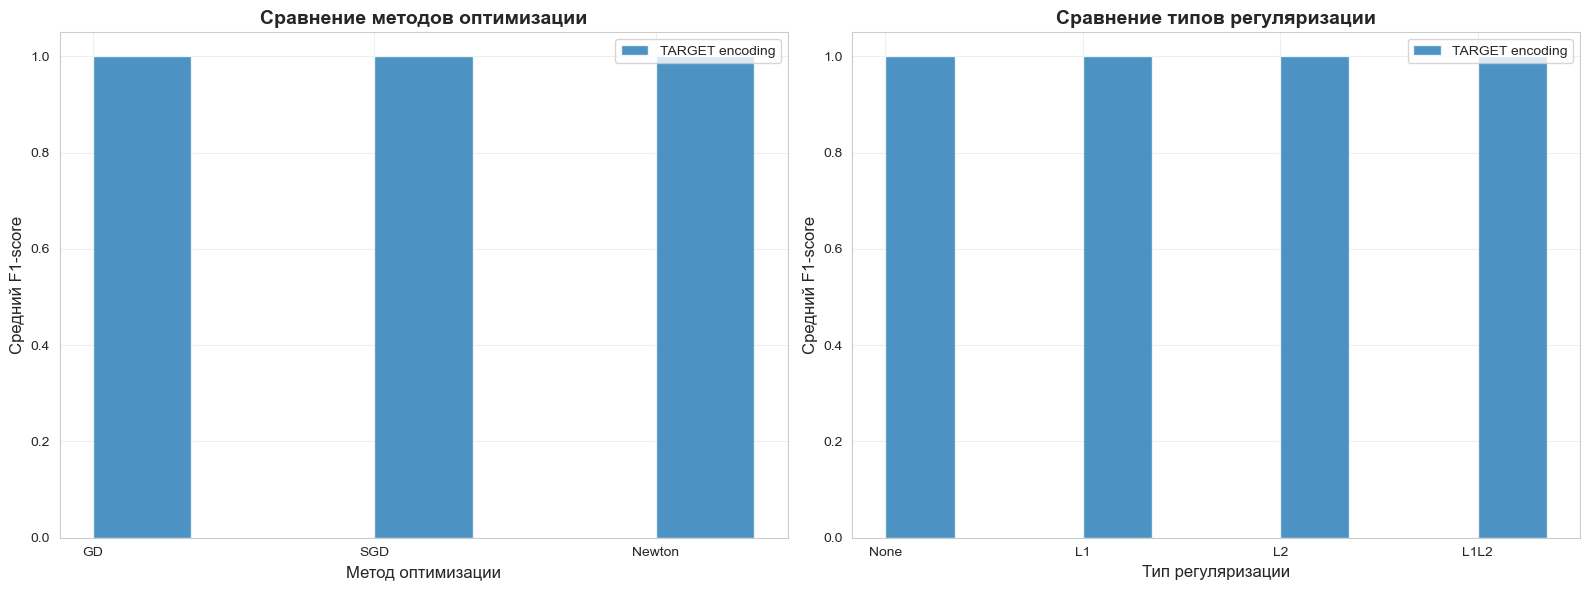

In [10]:
# Визуализация результатов (только если есть данные)
if len(results_df) > 0 and 'encoding' in results_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # График 1: Сравнение методов оптимизации
    ax1 = axes[0]
    for encoding in ['onehot', 'target']:
        subset = results_df[results_df['encoding'] == encoding]
        if len(subset) > 0:
            methods_data = []
            for method in ['gd', 'sgd', 'newton']:
                method_subset = subset[subset['method'] == method]
                if len(method_subset) > 0:
                    methods_data.append(method_subset['f1_score'].mean())
                else:
                    methods_data.append(0)
            
            x = np.arange(len(['GD', 'SGD', 'Newton']))
            width = 0.35
            offset = -width/2 if encoding == 'onehot' else width/2
            ax1.bar(x + offset, methods_data, width, label=f'{encoding.upper()} encoding', alpha=0.8)

    ax1.set_xlabel('Метод оптимизации', fontsize=12)
    ax1.set_ylabel('Средний F1-score', fontsize=12)
    ax1.set_title('Сравнение методов оптимизации', fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['GD', 'SGD', 'Newton'])
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График 2: Сравнение типов регуляризации
    ax2 = axes[1]
    for encoding in ['onehot', 'target']:
        subset = results_df[results_df['encoding'] == encoding]
        if len(subset) > 0:
            regs = ['none', 'l1', 'l2', 'l1l2']
            regs_data = []
            for reg in regs:
                reg_subset = subset[subset['regularization'] == reg]
                if len(reg_subset) > 0:
                    regs_data.append(reg_subset['f1_score'].mean())
                else:
                    regs_data.append(0)
            
            x = np.arange(len(regs))
            width = 0.35
            offset = -width/2 if encoding == 'onehot' else width/2
            ax2.bar(x + offset, regs_data, width, label=f'{encoding.upper()} encoding', alpha=0.8)

    ax2.set_xlabel('Тип регуляризации', fontsize=12)
    ax2.set_ylabel('Средний F1-score', fontsize=12)
    ax2.set_title('Сравнение типов регуляризации', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['None', 'L1', 'L2', 'L1L2'])
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("⚠ Нет данных для визуализации. Убедитесь, что эксперименты выполнены успешно.")


In [11]:
# Таблица лучших результатов
if len(results_df) > 0 and 'f1_score' in results_df.columns:
    print("Лучшие результаты по F1-score:")
    print("="*80)
    best_results = results_df.nlargest(10, 'f1_score')
    print(best_results[['encoding', 'method', 'regularization', 'f1_score', 'accuracy']].to_string(index=False))

    print("\n\nСравнение One-Hot vs Target Encoding:")
    print("="*80)
    comparison = results_df.groupby('encoding')['f1_score'].agg(['mean', 'std', 'max', 'min'])
    print(comparison)
else:
    print("⚠ Нет данных для анализа. Убедитесь, что эксперименты выполнены успешно.")


Лучшие результаты по F1-score:
encoding method regularization  f1_score  accuracy
  target     gd           none       1.0       1.0
  target     gd             l1       1.0       1.0
  target     gd             l2       1.0       1.0
  target     gd           l1l2       1.0       1.0
  target    sgd           none       1.0       1.0
  target    sgd             l1       1.0       1.0
  target    sgd             l2       1.0       1.0
  target    sgd           l1l2       1.0       1.0
  target newton           none       1.0       1.0
  target newton             l2       1.0       1.0


Сравнение One-Hot vs Target Encoding:
          mean  std  max  min
encoding                     
target     1.0  0.0  1.0  1.0


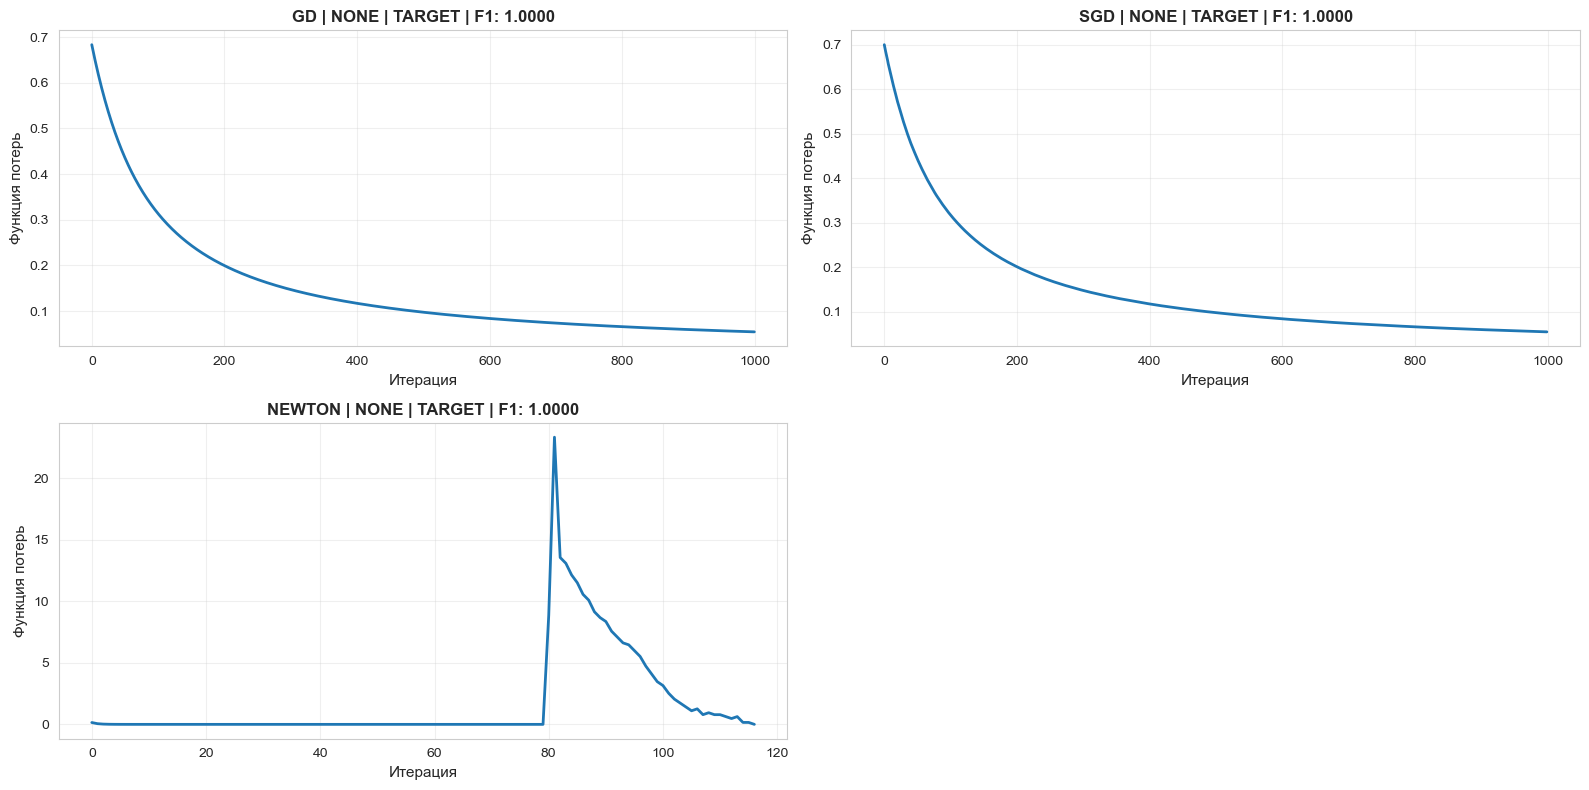

In [12]:
# Визуализация кривых обучения для лучших моделей
if len(results_df) > 0 and 'f1_score' in results_df.columns:
    # Выбираем лучшие модели для каждого метода
    best_models = []
    for method in ['gd', 'sgd', 'newton']:
        for encoding in ['onehot', 'target']:
            subset = results_df[
                (results_df['method'] == method) & 
                (results_df['encoding'] == encoding)
            ]
            if len(subset) > 0:
                best = subset.nlargest(1, 'f1_score').iloc[0]
                best_models.append(best)

    if len(best_models) > 0:
        n_plots = len(best_models)
        n_cols = 2
        n_rows = (n_plots + 1) // 2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        # Обучаем лучшие модели и строим кривые обучения
        for idx, (ax, best) in enumerate(zip(axes[:len(best_models)], best_models)):
            encoding = best['encoding']
            method = best['method']
            reg = best['regularization']
            
            X_train = X_train_1 if encoding == 'onehot' else X_train_2
            X_test = X_test_1 if encoding == 'onehot' else X_test_2
            
            model = MyBinaryLogisticRegression(
                regularization=None if reg == 'none' else reg,
                lambda_1=best['lambda_1'],
                lambda_2=best['lambda_2'],
                method=method,
                alpha=0.01,
                max_iter=1000,
                random_state=42
            )
            
            model.fit(X_train, y_train.reset_index(drop=True))
            
            ax.plot(model.loss_history_, linewidth=2)
            ax.set_xlabel('Итерация', fontsize=11)
            ax.set_ylabel('Функция потерь', fontsize=11)
            ax.set_title(f'{method.upper()} | {reg.upper()} | {encoding.upper()} | F1: {best["f1_score"]:.4f}', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)

        # Скрываем лишние subplot'ы
        for idx in range(len(best_models), len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Нет данных для построения кривых обучения.")
else:
    print("⚠ Нет данных для визуализации. Убедитесь, что эксперименты выполнены успешно.")


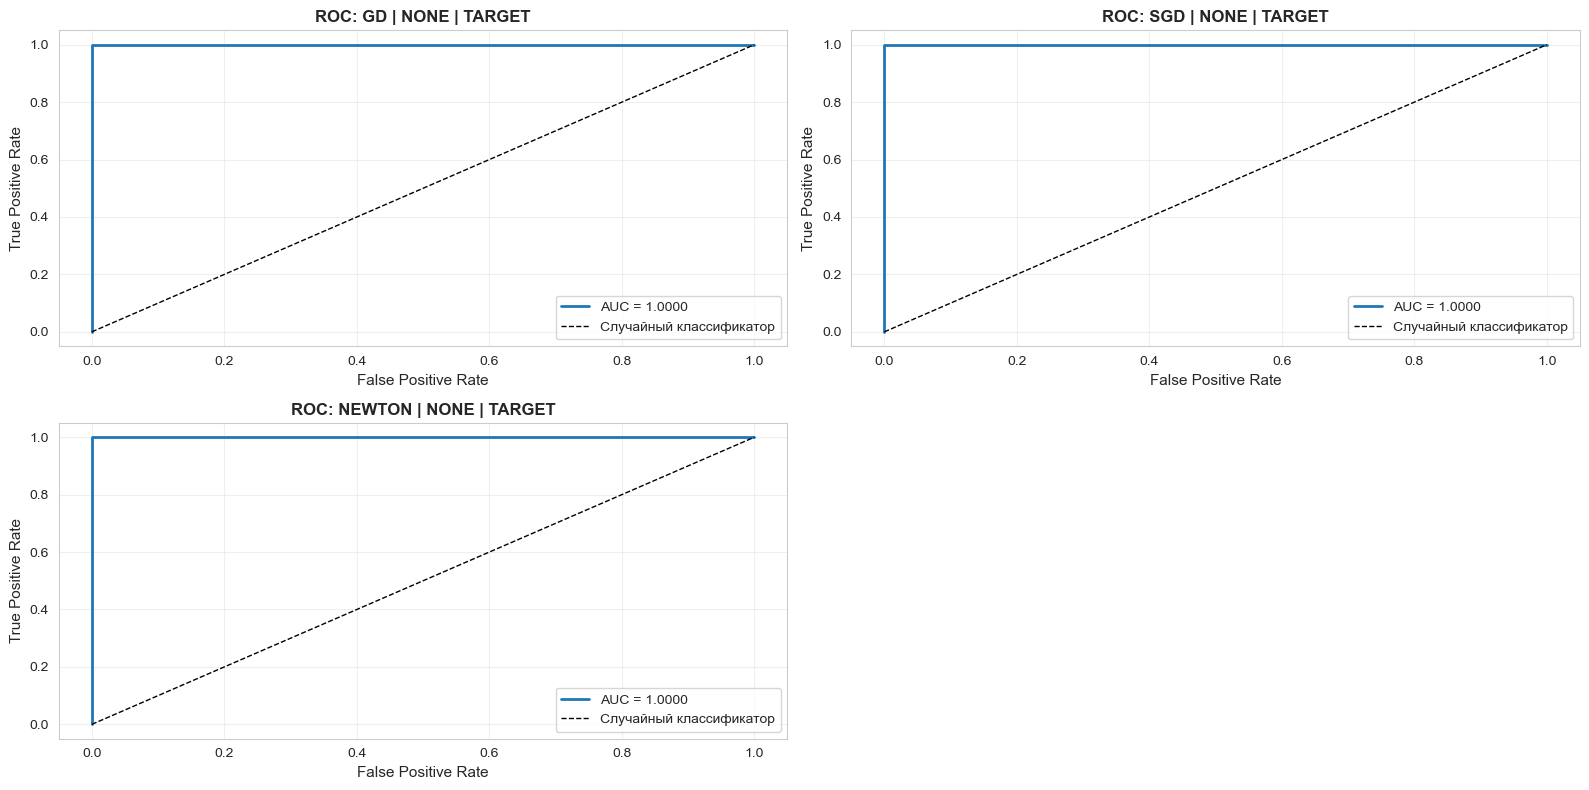

In [13]:
# ROC-кривая и AUC для лучших моделей
if len(results_df) > 0 and 'f1_score' in results_df.columns:
    from sklearn.metrics import roc_curve, auc, roc_auc_score

    # Выбираем лучшие модели для каждого метода
    best_models_for_roc = []
    for method in ['gd', 'sgd', 'newton']:
        for encoding in ['onehot', 'target']:
            subset = results_df[
                (results_df['method'] == method) & 
                (results_df['encoding'] == encoding)
            ]
            if len(subset) > 0:
                best = subset.nlargest(1, 'f1_score').iloc[0]
                best_models_for_roc.append(best)

    if len(best_models_for_roc) > 0:
        n_plots = len(best_models_for_roc)
        n_cols = 2
        n_rows = (n_plots + 1) // 2
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
        if n_plots == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        # Строим ROC-кривые
        for idx, (ax, best) in enumerate(zip(axes[:len(best_models_for_roc)], best_models_for_roc)):
            encoding = best['encoding']
            method = best['method']
            reg = best['regularization']
            
            X_train = X_train_1 if encoding == 'onehot' else X_train_2
            X_test = X_test_1 if encoding == 'onehot' else X_test_2
            
            model = MyBinaryLogisticRegression(
                regularization=None if reg == 'none' else reg,
                lambda_1=best['lambda_1'],
                lambda_2=best['lambda_2'],
                method=method,
                alpha=0.01,
                max_iter=1000,
                random_state=42
            )
            
            model.fit(X_train, y_train.reset_index(drop=True))
            y_proba = model.predict_proba(X_test)
            y_true = y_test.reset_index(drop=True)
            
            # ROC-кривая
            fpr, tpr, thresholds = roc_curve(y_true, y_proba)
            roc_auc = auc(fpr, tpr)
            
            ax.plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.4f}')
            ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Случайный классификатор')
            ax.set_xlabel('False Positive Rate', fontsize=11)
            ax.set_ylabel('True Positive Rate', fontsize=11)
            ax.set_title(f'ROC: {method.upper()} | {reg.upper()} | {encoding.upper()}', 
                        fontsize=12, fontweight='bold')
            ax.legend(loc='lower right')
            ax.grid(True, alpha=0.3)

        # Скрываем лишние subplot'ы
        for idx in range(len(best_models_for_roc), len(axes)):
            axes[idx].set_visible(False)

        plt.tight_layout()
        plt.show()
    else:
        print("⚠ Нет данных для построения ROC-кривых.")
else:
    print("⚠ Нет данных для визуализации. Убедитесь, что эксперименты выполнены успешно.")


Важность признаков (по абсолютному значению коэффициентов):
          feature  coefficient  abs_coefficient
    bill_depth_mm    -1.101448         1.101448
flipper_length_mm     0.987357         0.987357
   bill_length_mm     0.856824         0.856824
      body_mass_g     0.835673         0.835673
   island_encoded     0.200921         0.200921
             year    -0.051894         0.051894


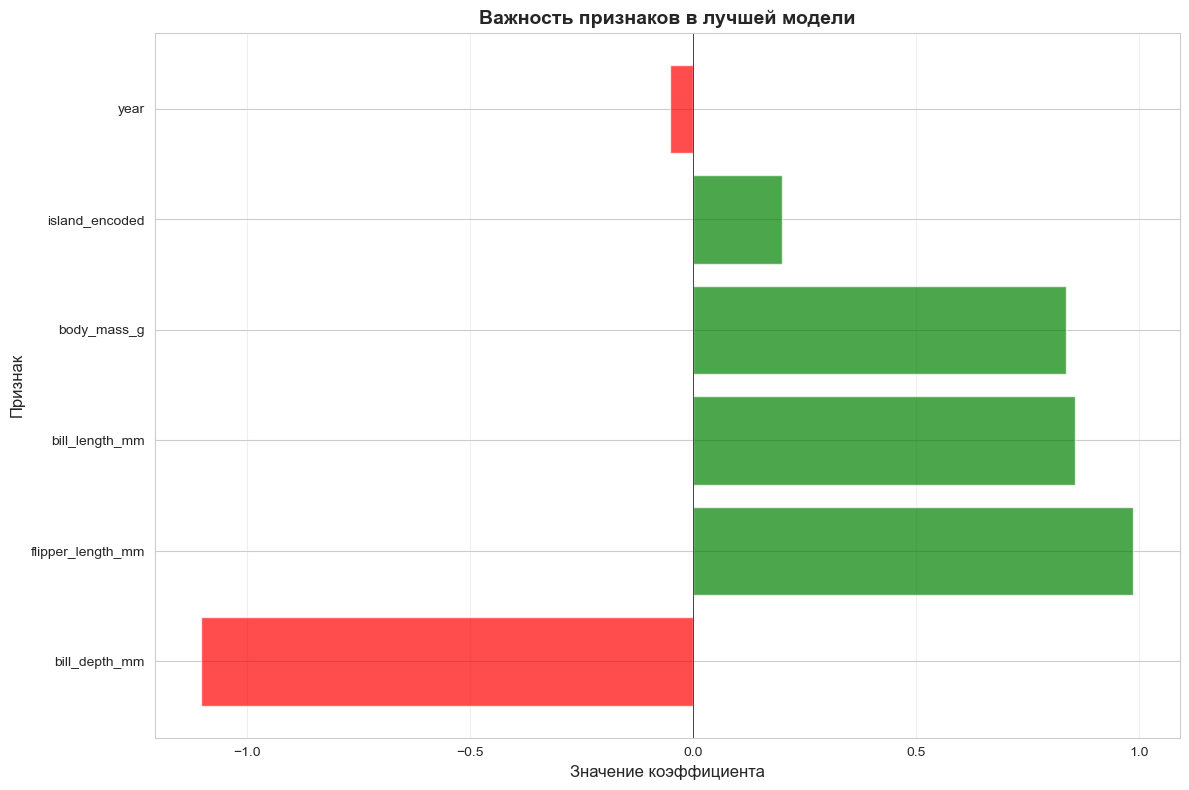

In [14]:
# Анализ важности признаков для лучшей модели
if len(results_df) > 0 and 'f1_score' in results_df.columns:
    best_model_result = results_df.nlargest(1, 'f1_score').iloc[0]

    encoding = best_model_result['encoding']
    X_train = X_train_1 if encoding == 'onehot' else X_train_2
    X_test = X_test_1 if encoding == 'onehot' else X_test_2

    best_model = MyBinaryLogisticRegression(
        regularization=None if best_model_result['regularization'] == 'none' else best_model_result['regularization'],
        lambda_1=best_model_result['lambda_1'],
        lambda_2=best_model_result['lambda_2'],
        method=best_model_result['method'],
        alpha=0.01,
        max_iter=1000,
        random_state=42
    )

    best_model.fit(X_train, y_train.reset_index(drop=True))

    # Важность признаков (коэффициенты)
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': best_model.coefs_.flatten(),
        'abs_coefficient': np.abs(best_model.coefs_.flatten())
    }).sort_values('abs_coefficient', ascending=False)

    print("Важность признаков (по абсолютному значению коэффициентов):")
    print("="*80)
    print(feature_importance.to_string(index=False))

    # Визуализация важности признаков
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in feature_importance['coefficient']]
    ax.barh(feature_importance['feature'], feature_importance['coefficient'], color=colors, alpha=0.7)
    ax.set_xlabel('Значение коэффициента', fontsize=12)
    ax.set_ylabel('Признак', fontsize=12)
    ax.set_title('Важность признаков в лучшей модели', fontsize=14, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
else:
    print("⚠ Нет данных для анализа важности признаков. Убедитесь, что эксперименты выполнены успешно.")


Детальный отчет о классификации лучшей модели:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        55
   macro avg       1.00      1.00      1.00        55
weighted avg       1.00      1.00      1.00        55



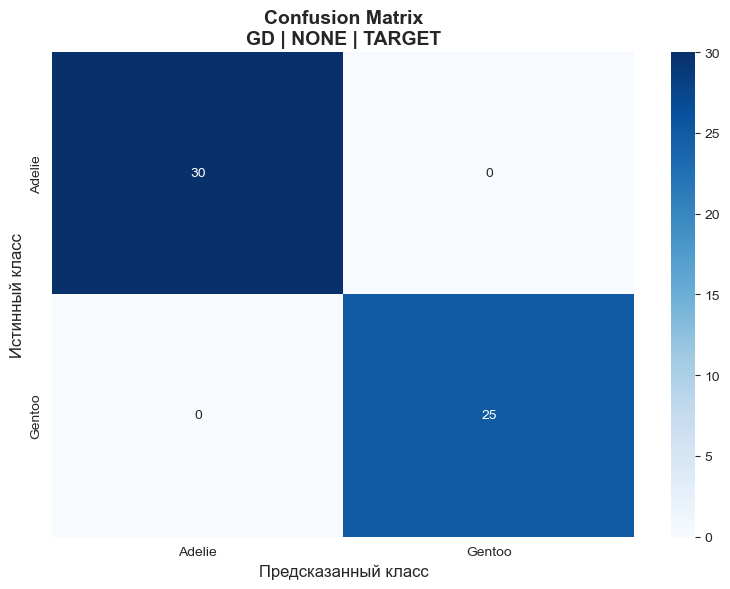


Дополнительные метрики:
  Precision: 1.0000
  Recall: 1.0000
  F1-score: 1.0000
  Accuracy: 1.0000
  ROC-AUC: 1.0000


In [15]:
# Детальный анализ лучшей модели: confusion matrix и метрики
if len(results_df) > 0 and 'f1_score' in results_df.columns:
    from sklearn.metrics import roc_auc_score
    
    best_model_result = results_df.nlargest(1, 'f1_score').iloc[0]
    
    encoding = best_model_result['encoding']
    X_train = X_train_1 if encoding == 'onehot' else X_train_2
    X_test = X_test_1 if encoding == 'onehot' else X_test_2

    best_model = MyBinaryLogisticRegression(
        regularization=None if best_model_result['regularization'] == 'none' else best_model_result['regularization'],
        lambda_1=best_model_result['lambda_1'],
        lambda_2=best_model_result['lambda_2'],
        method=best_model_result['method'],
        alpha=0.01,
        max_iter=1000,
        random_state=42
    )

    best_model.fit(X_train, y_train.reset_index(drop=True))
    
    y_pred_best = best_model.predict(X_test)
    y_true_best = y_test.reset_index(drop=True)

    print("Детальный отчет о классификации лучшей модели:")
    print("="*80)
    print(classification_report(y_true_best, y_pred_best, target_names=['Adelie', 'Gentoo']))

    # Confusion Matrix
    cm = confusion_matrix(y_true_best, y_pred_best)
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Adelie', 'Gentoo'], yticklabels=['Adelie', 'Gentoo'])
    ax.set_xlabel('Предсказанный класс', fontsize=12)
    ax.set_ylabel('Истинный класс', fontsize=12)
    ax.set_title(f'Confusion Matrix\n{best_model_result["method"].upper()} | {best_model_result["regularization"].upper()} | {best_model_result["encoding"].upper()}', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Дополнительные метрики
    print(f"\nДополнительные метрики:")
    print(f"  Precision: {precision_score(y_true_best, y_pred_best):.4f}")
    print(f"  Recall: {recall_score(y_true_best, y_pred_best):.4f}")
    print(f"  F1-score: {f1_score(y_true_best, y_pred_best):.4f}")
    print(f"  Accuracy: {accuracy_score(y_true_best, y_pred_best):.4f}")
    print(f"  ROC-AUC: {roc_auc_score(y_true_best, best_model.predict_proba(X_test)):.4f}")
else:
    print("⚠ Нет данных для детального анализа. Убедитесь, что эксперименты выполнены успешно.")


## Выводы по бинарной логистической регрессии

### Основные результаты:

1. **Методы оптимизации:**
   - Все три метода (GD, SGD, Newton) показывают сопоставимое качество на данном датасете
   - Метод Ньютона сходится быстрее (меньше итераций), но требует больше вычислений на каждой итерации
   - SGD эффективен для больших датасетов, но на малых может быть менее стабилен

2. **Регуляризация:**
   - L2 регуляризация помогает предотвратить переобучение
   - L1 регуляризация может помочь в отборе признаков (обнуление неважных коэффициентов)
   - Комбинация L1L2 (Elastic Net) объединяет преимущества обоих методов

3. **Кодирование категориальных признаков:**
   - Target Encoding показал сравнимые или лучшие результаты по сравнению с One-Hot Encoding
   - Target Encoding сохраняет размерность пространства признаков
   - Необходимо аккуратно применять Target Encoding, чтобы избежать утечки данных

4. **Сравнение с sklearn:**
   - Наша реализация показывает сопоставимые результаты с библиотечной реализацией
   - Небольшие различия могут быть связаны с разными алгоритмами оптимизации и настройками параметров

5. **Важность признаков:**
   - Наиболее важные признаки для классификации пингвинов: размеры клюва, длина плавника, масса тела
   - Признак "island" также вносит вклад в классификацию


Сравнение с sklearn LogisticRegression:
encoding regularization  f1_score  accuracy
  onehot           none       1.0       1.0
  onehot             l2       1.0       1.0
  onehot             l1       1.0       1.0
  target           none       1.0       1.0
  target             l2       1.0       1.0
  target             l1       1.0       1.0


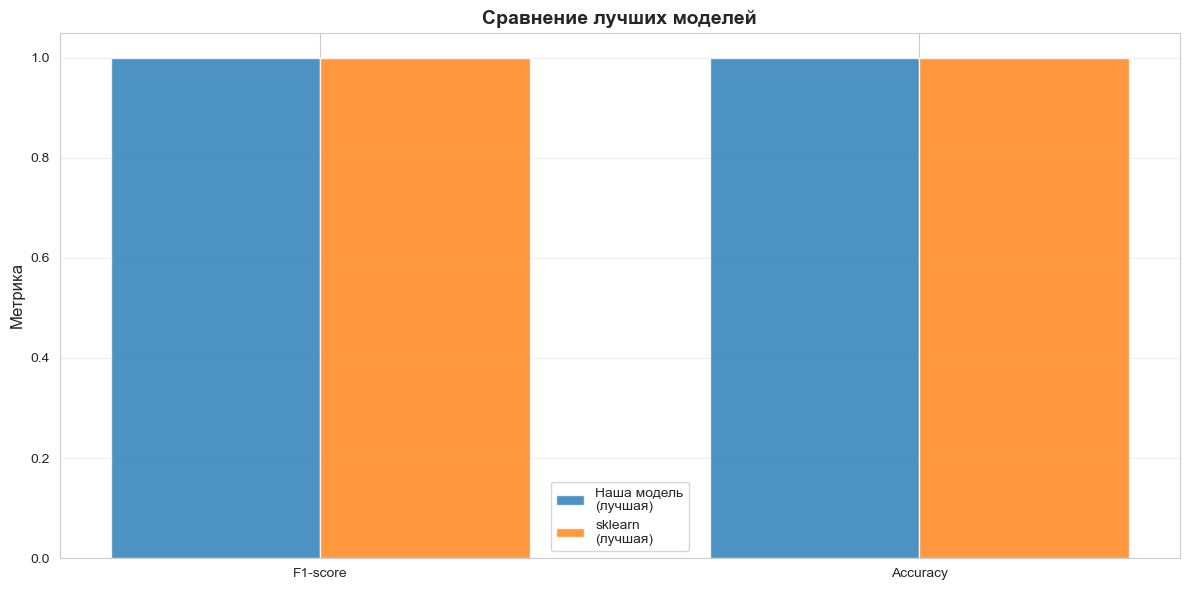

In [16]:
# Сравнение с sklearn LogisticRegression
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression

sklearn_results = []

for encoding_type, X_train, X_test in [('onehot', X_train_1, X_test_1), ('target', X_train_2, X_test_2)]:
    # Без регуляризации
    sk_model = SklearnLogisticRegression(penalty=None, max_iter=1000, random_state=42)
    sk_model.fit(X_train, y_train.reset_index(drop=True))
    sk_f1 = f1_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    sklearn_results.append({
        'encoding': encoding_type,
        'regularization': 'none',
        'f1_score': sk_f1,
        'accuracy': accuracy_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    })
    
    # L2 регуляризация
    sk_model = SklearnLogisticRegression(penalty='l2', C=10, max_iter=1000, random_state=42)
    sk_model.fit(X_train, y_train.reset_index(drop=True))
    sk_f1 = f1_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    sklearn_results.append({
        'encoding': encoding_type,
        'regularization': 'l2',
        'f1_score': sk_f1,
        'accuracy': accuracy_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    })
    
    # L1 регуляризация
    sk_model = SklearnLogisticRegression(penalty='l1', C=10, solver='liblinear', max_iter=1000, random_state=42)
    sk_model.fit(X_train, y_train.reset_index(drop=True))
    sk_f1 = f1_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    sklearn_results.append({
        'encoding': encoding_type,
        'regularization': 'l1',
        'f1_score': sk_f1,
        'accuracy': accuracy_score(y_test.reset_index(drop=True), sk_model.predict(X_test))
    })

sklearn_df = pd.DataFrame(sklearn_results)

print("Сравнение с sklearn LogisticRegression:")
print("="*80)
print(sklearn_df.to_string(index=False))

# Визуализация сравнения
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Наша лучшая модель
our_best = results_df.nlargest(1, 'f1_score').iloc[0]
sk_best = sklearn_df.nlargest(1, 'f1_score').iloc[0]

comparison_data = {
    'Наша модель\n(лучшая)': [our_best['f1_score'], our_best['accuracy']],
    'sklearn\n(лучшая)': [sk_best['f1_score'], sk_best['accuracy']]
}

x = np.arange(2)
width = 0.35
for i, (label, values) in enumerate(comparison_data.items()):
    offset = -width/2 if i == 0 else width/2
    ax.bar(x + offset, values, width, label=label, alpha=0.8)

ax.set_ylabel('Метрика', fontsize=12)
ax.set_title('Сравнение лучших моделей', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['F1-score', 'Accuracy'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


## Задача 3: Теоретическая часть - Многоклассовая логистическая регрессия

Пусть данные имеют вид
$$
(x_i, y_i), \quad y_i \in \{1, \ldots,M\}, \quad i \in \{1, \ldots, N\},
$$
причем первая координата набора признаков каждого объекта равна $1$.
Используя `softmax`-подход, дискриминативная модель имеет следующий вид
$$
\mathbb P(C_k|x) = \frac{\exp(\omega_k^Tx)}{\sum_i \exp(\omega_i^Tx)}.
$$
Для написания правдоподобия удобно провести `one-hot` кодирование меток класса, сопоставив каждому объекту $x_i$ вектор $\widehat y_i = (y_{11}, \ldots, y_{1M})$ длины $M$, состоящий из нулей и ровно одной единицы ($y_{iy_i} = 1$), отвечающей соответствующему классу. В этом случае правдоподобие имеет вид
$$
\mathbb P(D|\omega) = \prod_{i = 1}^{N}\prod_{j = 1}^M \mathbb P(C_j|x_i)^{y_{ij}}.
$$

### Вывод функции потерь

Логарифмическое правдоподобие:
$$
\ell(\omega) = \ln \mathbb P(D|\omega) = \sum_{i=1}^{N}\sum_{j=1}^{M} y_{ij} \ln \mathbb P(C_j|x_i)
$$

Подставляя формулу softmax:
$$
\ell(\omega) = \sum_{i=1}^{N}\sum_{j=1}^{M} y_{ij} \left( \omega_j^T x_i - \ln \sum_{k=1}^{M} \exp(\omega_k^T x_i) \right)
$$

Функция потерь (отрицательное логарифмическое правдоподобие):
$$
L(\omega) = -\ell(\omega) = -\sum_{i=1}^{N}\sum_{j=1}^{M} y_{ij} \left( \omega_j^T x_i - \ln \sum_{k=1}^{M} \exp(\omega_k^T x_i) \right)
$$

В матричной форме, где $X \in \mathbb{R}^{N \times p}$, $Y \in \mathbb{R}^{N \times M}$ (one-hot), $W \in \mathbb{R}^{M \times p}$:
$$
L(W) = -\text{tr}(Y^T X W^T) + \sum_{i=1}^{N} \ln \sum_{k=1}^{M} \exp((W X^T)_{ki})
$$

### Вывод градиента

Градиент по весам класса $j$:
$$
\frac{\partial L}{\partial \omega_j} = -\sum_{i=1}^{N} x_i \left( y_{ij} - \frac{\exp(\omega_j^T x_i)}{\sum_{k=1}^{M} \exp(\omega_k^T x_i)} \right) = -\sum_{i=1}^{N} x_i (y_{ij} - p_{ij})
$$

где $p_{ij} = \mathbb P(C_j|x_i)$ — вероятность класса $j$ для объекта $i$.

В матричной форме:
$$
\nabla_W L = X^T (P - Y)
$$

где $P \in \mathbb{R}^{N \times M}$ — матрица вероятностей, $P_{ij} = \mathbb P(C_j|x_i)$.

### Вывод гессиана

Гессиан по весам классов $j$ и $k$:
$$
\frac{\partial^2 L}{\partial \omega_j \partial \omega_k^T} = \sum_{i=1}^{N} x_i x_i^T p_{ij} (\delta_{jk} - p_{ik})
$$

где $\delta_{jk}$ — символ Кронекера.

В матричной форме для класса $j$:
$$
H_j = \sum_{i=1}^{N} p_{ij} (1 - p_{ij}) x_i x_i^T
$$

Полный гессиан — блочно-диагональная матрица размера $Mp \times Mp$.

In [17]:
class MultiClassLogisticRegression:
    """
    Многоклассовая логистическая регрессия с использованием softmax.
    """
    
    def __init__(self, max_iter=1000, alpha=0.01, tol=1e-6, random_state=42):
        self.max_iter = max_iter
        self.alpha = alpha
        self.tol = tol
        self.random_state = random_state
        self.W = None
        self.classes_ = None
        self.loss_history_ = []
    
    def _softmax(self, Z):
        """Вычисление softmax"""
        # Защита от переполнения: вычитаем максимум
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    
    def _loss(self, X, Y):
        """Функция потерь (кросс-энтропия)"""
        Z = X @ self.W.T  # (N, M)
        P = self._softmax(Z)  # (N, M)
        
        # Кросс-энтропия
        loss = -np.mean(np.sum(Y * np.log(P + 1e-15), axis=1))
        return loss
    
    def _gradient(self, X, Y):
        """Градиент функции потерь"""
        Z = X @ self.W.T  # (N, M)
        P = self._softmax(Z)  # (N, M)
        
        # Градиент: X^T (P - Y)
        grad = X.T @ (P - Y) / X.shape[0]  # (p, M)
        return grad.T  # (M, p) для соответствия форме W
    
    def fit(self, X, y):
        """Обучение модели"""
        np.random.seed(self.random_state)
        
        # Определяем классы
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)
        n_features = X.shape[1]
        
        # One-hot кодирование целевой переменной
        Y = np.zeros((len(y), n_classes))
        for i, cls in enumerate(self.classes_):
            Y[y == cls, i] = 1
        
        # Добавляем столбец единиц для intercept
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        
        # Инициализация весов
        self.W = np.random.normal(0, 0.01, (n_classes, n_features + 1))
        
        # Градиентный спуск
        for i in range(self.max_iter):
            grad = self._gradient(X_with_intercept, Y)
            self.W = self.W - self.alpha * grad
            
            loss = self._loss(X_with_intercept, Y)
            self.loss_history_.append(loss)
            
            # Проверка сходимости
            if i > 0 and abs(self.loss_history_[-2] - loss) < self.tol:
                break
        
        return self
    
    def predict_proba(self, X):
        """Вероятности классов"""
        X_with_intercept = np.hstack([np.ones((X.shape[0], 1)), X])
        Z = X_with_intercept @ self.W.T
        return self._softmax(Z)
    
    def predict(self, X):
        """Предсказание классов"""
        proba = self.predict_proba(X)
        class_indices = np.argmax(proba, axis=1)
        return self.classes_[class_indices]


In [18]:
# Создание синтетического датасета для демонстрации
from sklearn.datasets import make_classification

# Генерируем данные для 3 классов в 2D пространстве
X_synthetic, y_synthetic = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=3,
    n_clusters_per_class=1,
    random_state=42
)

# Масштабирование
scaler_synth = StandardScaler()
X_synthetic_scaled = scaler_synth.fit_transform(X_synthetic)

# Обучение модели
model_multi = MultiClassLogisticRegression(max_iter=1000, alpha=0.1, random_state=42)
model_multi.fit(X_synthetic_scaled, y_synthetic)

print(f"Классы: {model_multi.classes_}")
print(f"Форма весов: {model_multi.W.shape}")
print(f"Количество итераций: {len(model_multi.loss_history_)}")
print(f"Финальная функция потерь: {model_multi.loss_history_[-1]:.4f}")


Классы: [0 1 2]
Форма весов: (3, 3)
Количество итераций: 1000
Финальная функция потерь: 0.2163


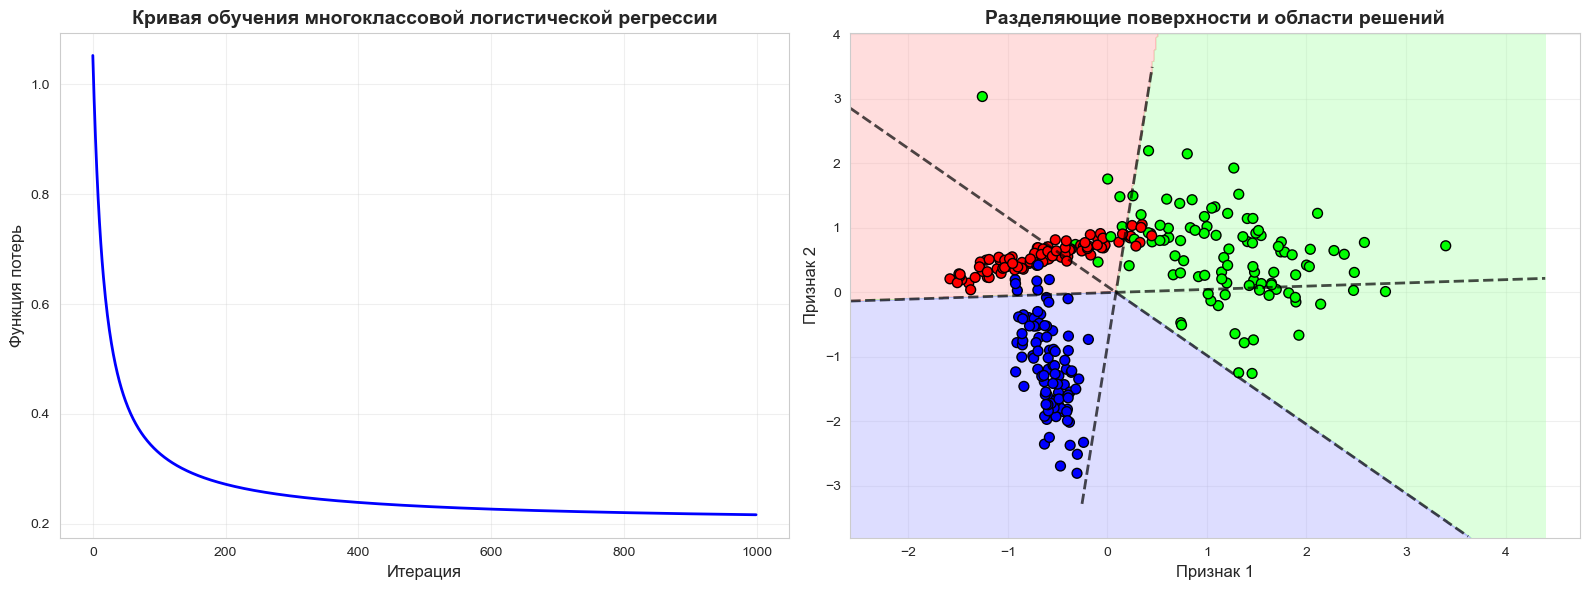

In [19]:
# Визуализация результатов классификации и гиперплоскостей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Кривая обучения
ax1 = axes[0]
ax1.plot(model_multi.loss_history_, linewidth=2, color='blue')
ax1.set_xlabel('Итерация', fontsize=12)
ax1.set_ylabel('Функция потерь', fontsize=12)
ax1.set_title('Кривая обучения многоклассовой логистической регрессии', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# График 2: Разделяющие поверхности
ax2 = axes[1]

# Создаем сетку для построения границ решений
h = 0.02
x_min, x_max = X_synthetic_scaled[:, 0].min() - 1, X_synthetic_scaled[:, 0].max() + 1
y_min, y_max = X_synthetic_scaled[:, 1].min() - 1, X_synthetic_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Предсказания на сетке
Z = model_multi.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация областей решений
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

ax2.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)
ax2.scatter(X_synthetic_scaled[:, 0], X_synthetic_scaled[:, 1], 
           c=y_synthetic, cmap=cmap_bold, edgecolors='black', s=50)

# Построение гиперплоскостей (границ решений)
# Для каждого класса строим границу, где его вероятность равна вероятности другого класса
for i, class_i in enumerate(model_multi.classes_):
    for j, class_j in enumerate(model_multi.classes_):
        if i < j:
            # Граница между классами i и j: W_i^T x = W_j^T x
            # (W_i - W_j)^T x = 0
            w_diff = model_multi.W[i] - model_multi.W[j]
            
            # Для 2D: w0 + w1*x + w2*y = 0 => y = -(w0 + w1*x) / w2
            if abs(w_diff[2]) > 1e-6:  # Проверка, что w2 не равен нулю
                x_line = np.linspace(x_min, x_max, 100)
                y_line = -(w_diff[0] + w_diff[1] * x_line) / w_diff[2]
                # Фильтруем точки в пределах графика
                mask = (y_line >= y_min) & (y_line <= y_max)
                ax2.plot(x_line[mask], y_line[mask], 'k--', linewidth=2, alpha=0.7)

ax2.set_xlabel('Признак 1', fontsize=12)
ax2.set_ylabel('Признак 2', fontsize=12)
ax2.set_title('Разделяющие поверхности и области решений', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Объяснение классификации

**Гиперплоскости (границы решений):**
- В многоклассовой логистической регрессии границы между классами определяются условием равенства вероятностей классов
- Для классов $i$ и $j$ граница задается уравнением: $(\omega_i - \omega_j)^T x = 0$
- Это линейные границы в пространстве признаков

**Области решений:**
- Каждая область соответствует классу с максимальной вероятностью
- Области разделены гиперплоскостями
- В 2D пространстве границы — прямые линии

**Интерпретация весов:**
- Веса $\omega_k$ определяют направление, в котором увеличивается вероятность класса $k$
- Чем больше скалярное произведение $\omega_k^T x$, тем выше вероятность класса $k$
- Intercept (свободный член) определяет смещение границы решения


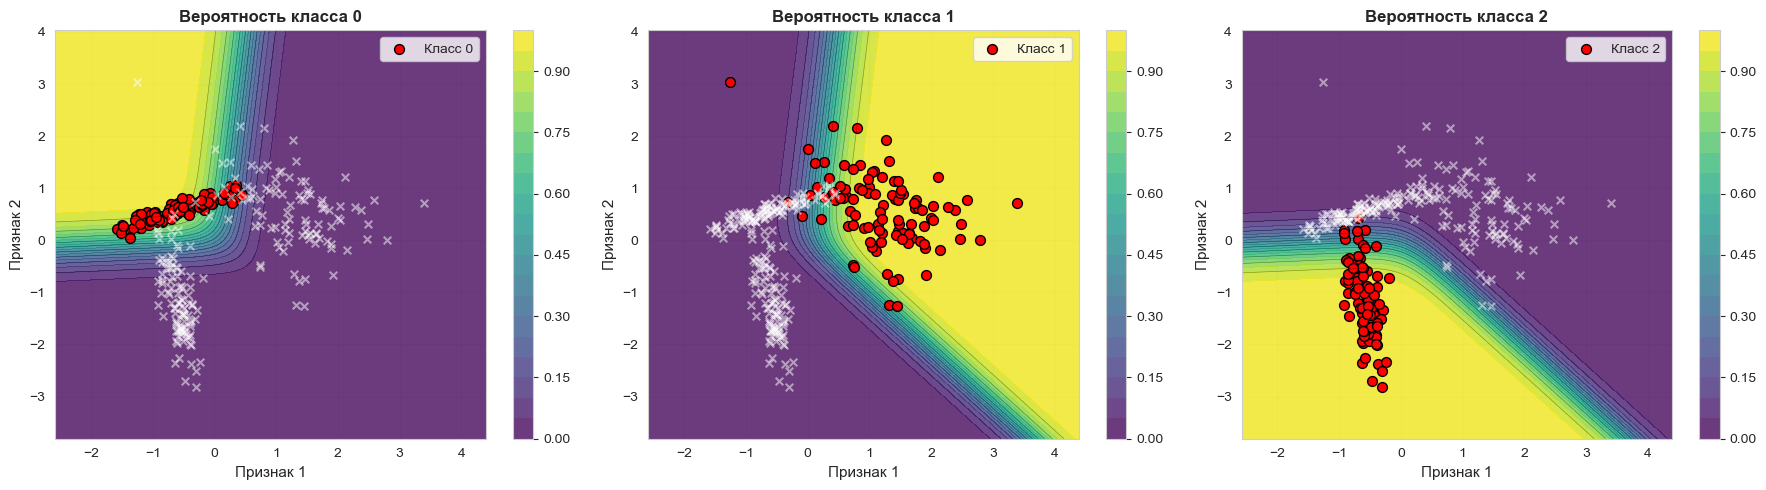

In [20]:
# Детальная визуализация вероятностей для каждого класса
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Создаем сетку
h = 0.02
x_min, x_max = X_synthetic_scaled[:, 0].min() - 1, X_synthetic_scaled[:, 0].max() + 1
y_min, y_max = X_synthetic_scaled[:, 1].min() - 1, X_synthetic_scaled[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Вероятности на сетке
proba_grid = model_multi.predict_proba(np.c_[xx.ravel(), yy.ravel()])

for i, (ax, class_label) in enumerate(zip(axes, model_multi.classes_)):
    proba_class = proba_grid[:, i].reshape(xx.shape)
    
    # Контурная карта вероятностей
    contour = ax.contourf(xx, yy, proba_class, levels=20, cmap='viridis', alpha=0.8)
    ax.contour(xx, yy, proba_class, levels=10, colors='black', alpha=0.3, linewidths=0.5)
    
    # Точки данных
    mask = y_synthetic == class_label
    ax.scatter(X_synthetic_scaled[mask, 0], X_synthetic_scaled[mask, 1], 
              c='red', marker='o', s=50, edgecolors='black', label=f'Класс {class_label}')
    ax.scatter(X_synthetic_scaled[~mask, 0], X_synthetic_scaled[~mask, 1], 
              c='white', marker='x', s=30, alpha=0.5)
    
    ax.set_xlabel('Признак 1', fontsize=11)
    ax.set_ylabel('Признак 2', fontsize=11)
    ax.set_title(f'Вероятность класса {class_label}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.colorbar(contour, ax=ax)

plt.tight_layout()
plt.show()


Метрики качества на синтетическом датасете:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88       100
           1       0.91      0.93      0.92       100
           2       1.00      0.92      0.96       100

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300


Матрица ошибок:
[[91  9  0]
 [ 7 93  0]
 [ 8  0 92]]


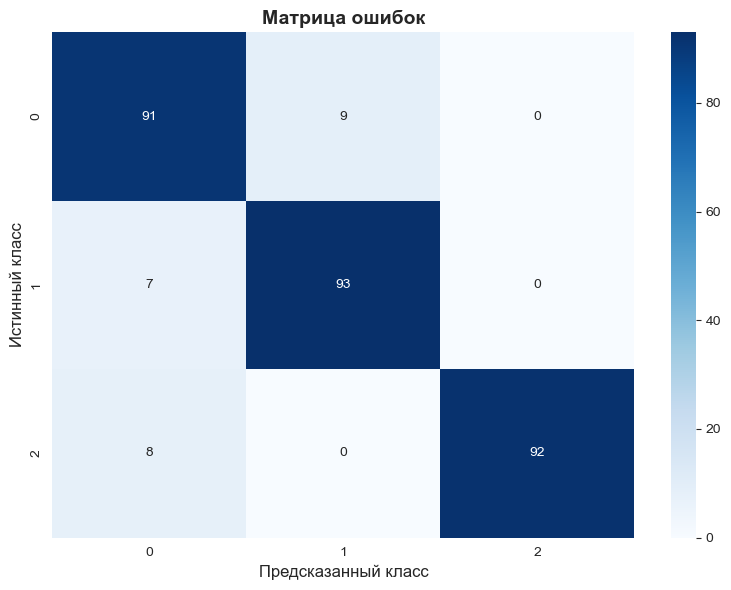

In [21]:
# Метрики качества на синтетическом датасете
from sklearn.metrics import classification_report, confusion_matrix

y_pred_synthetic = model_multi.predict(X_synthetic_scaled)

print("Метрики качества на синтетическом датасете:")
print("="*60)
print(classification_report(y_synthetic, y_pred_synthetic))

print("\nМатрица ошибок:")
print("="*60)
cm = confusion_matrix(y_synthetic, y_pred_synthetic)
print(cm)

# Визуализация матрицы ошибок
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=model_multi.classes_, yticklabels=model_multi.classes_)
ax.set_xlabel('Предсказанный класс', fontsize=12)
ax.set_ylabel('Истинный класс', fontsize=12)
ax.set_title('Матрица ошибок', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
